<div style="text-align: right"><b> Ana Valentina López Chacón </b></div>
<div style="text-align: right"><b> Reconocimiento de Formas, 2024 - 2025 </b></div>

## **Clasificación de Animales: Transfer Learning y Aumento de Datos**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import keras
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0
from keras.applications.resnet_v2 import ResNet50V2, decode_predictions, preprocess_input
keras.utils.set_random_seed(23)


Realizamos la lectura de los datos.

In [2]:
dataset_path = '/kaggle/input/animals10/raw-img'

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
num_clases = 10

train_dataset = image_dataset_from_directory(
    dataset_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=True,
    validation_split=0.2,
    subset='training',
    seed=123
)


test_dataset = image_dataset_from_directory(
    dataset_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=True,
    validation_split=0.2,
    subset='validation',
    seed=123
)

validation_split = 0.25  
num_validation_batches = int(validation_split * len(train_dataset)) #.file_paths
validation_dataset = train_dataset.take(num_validation_batches)
train_dataset = train_dataset.skip(num_validation_batches)

Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.


### **EfficientNetB0**

In [3]:
inputs = keras.Input(shape=(224, 224, 3))
#x = keras.layers.Rescaling(scale = 1/255)(inputs)
factor_ag = 0.04
x = keras.layers.RandomRotation(factor_ag, fill_mode="nearest")(inputs)
x = keras.layers.RandomTranslation(factor_ag, factor_ag, fill_mode="nearest")(x)
x = keras.layers.RandomZoom(factor_ag, fill_mode="nearest")(x)
x = keras.layers.RandomFlip(mode="horizontal")(x)
base_M = EfficientNetB0(weights='imagenet', include_top=False)
base_M.trainable = False
x = base_M(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(units = 512, activation ='relu')(x)
x = keras.layers.Dropout(0.5)(x)
predictions = keras.layers.Dense(10, activation='softmax')(x)
M = keras.models.Model(inputs=inputs, outputs=predictions)
opt = keras.optimizers.Adam(learning_rate=0.001)
M.compile(loss="SparseCategoricalCrossentropy", optimizer=opt, metrics=["SparseCategoricalAccuracy"])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
M.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation              │ (None, 224, 224, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,710,573 (17.97 MB)

 Trainable params: 661,002 (2.52 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [5]:
filename = 'Proyecto_tfag_EfficientNetB0.keras'
checkpoint_cb = keras.callbacks.ModelCheckpoint(
 filepath=filename, monitor='val_SparseCategoricalAccuracy', save_best_only=True, verbose=1)
reduce_cb = keras.callbacks.ReduceLROnPlateau(
 monitor='val_SparseCategoricalAccuracy', factor=0.2585, patience=5, min_delta=0.0005, min_lr=1e-5)
early_cb = keras.callbacks.EarlyStopping(monitor='val_SparseCategoricalAccuracy', patience=5, min_delta=0.0005, mode='max')
#H = M.fit(x_train, y_train, batch_size=16, epochs=25, validation_data=(x_val, y_val), verbose=0,
 #callbacks=[checkpoint_cb, early_cb, reduce_cb])
H = M.fit(train_dataset, batch_size=128, epochs=100, validation_data=validation_dataset, verbose=0,
 callbacks=[checkpoint_cb, early_cb, reduce_cb])

2024-10-16 01:33:23.462689: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer



Epoch 1: val_SparseCategoricalAccuracy improved from inf to 0.96913, saving model to Proyecto_tfag_EfficientNetB0.keras

Epoch 2: val_SparseCategoricalAccuracy did not improve from 0.96913

Epoch 3: val_SparseCategoricalAccuracy did not improve from 0.96913

Epoch 4: val_SparseCategoricalAccuracy improved from 0.96913 to 0.96894, saving model to Proyecto_tfag_EfficientNetB0.keras

Epoch 5: val_SparseCategoricalAccuracy did not improve from 0.96894

Epoch 6: val_SparseCategoricalAccuracy did not improve from 0.96894

Epoch 7: val_SparseCategoricalAccuracy did not improve from 0.96894

Epoch 8: val_SparseCategoricalAccuracy did not improve from 0.96894

Epoch 9: val_SparseCategoricalAccuracy did not improve from 0.96894

Epoch 10: val_SparseCategoricalAccuracy did not improve from 0.96894

Epoch 11: val_SparseCategoricalAccuracy did not improve from 0.96894

Epoch 12: val_SparseCategoricalAccuracy did not improve from 0.96894

Epoch 13: val_SparseCategoricalAccuracy did not improve from

In [6]:
score = M.evaluate(test_dataset, verbose=0)
print(f'Loss: {score[0]:.4}\nPrecisión: {score[1]:.2%}')

Loss: 0.1005
Precisión: 97.50%


Realizamos la gráfica para losses, accuracy, matriz de confusión y reporte de clasificación.

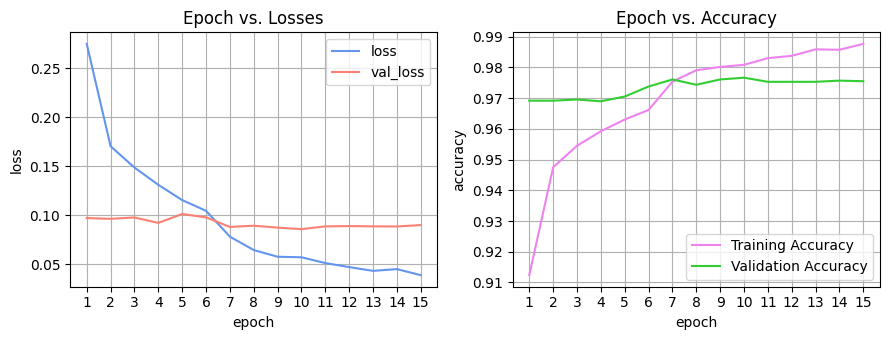

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))
xx = np.arange(1, len(H.history['loss'])+1)
ax = axes[0]
ax.grid()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title("Epoch vs. Losses")
ax.set_xticks(xx)
ax.plot(xx, H.history['loss'], label = 'loss', color='cornflowerblue')
ax.plot(xx, H.history['val_loss'], label = 'val_loss', color='salmon')
ax.legend()

ax = axes[1]
ax.grid()
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.set_title("Epoch vs. Accuracy")
ax.set_xticks(xx)
ax.plot(xx, H.history['SparseCategoricalAccuracy'], label='Training Accuracy', color='violet')
ax.plot(xx, H.history['val_SparseCategoricalAccuracy'], label='Validation Accuracy', color = 'limegreen')
ax.legend()
plt.tight_layout()

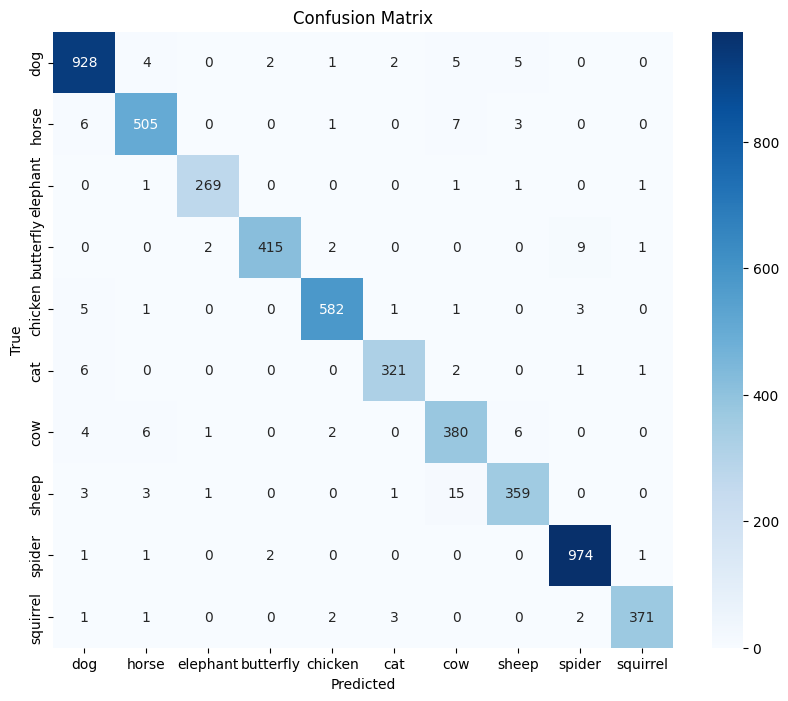

              precision    recall  f1-score   support

         dog       0.97      0.98      0.98       947
       horse       0.97      0.97      0.97       522
    elephant       0.99      0.99      0.99       273
   butterfly       0.99      0.97      0.98       429
     chicken       0.99      0.98      0.98       593
         cat       0.98      0.97      0.97       331
         cow       0.92      0.95      0.94       399
       sheep       0.96      0.94      0.95       382
      spider       0.98      0.99      0.99       979
    squirrel       0.99      0.98      0.98       380

    accuracy                           0.97      5235
   macro avg       0.97      0.97      0.97      5235
weighted avg       0.98      0.97      0.97      5235



In [8]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def get_labels_and_predictions(dataset, model):
    true_labels = []
    predictions = []

    for images, labels in dataset:
        preds = model.predict(images, verbose = 0)
        predicted_classes = np.argmax(preds, axis=1)
        true_labels.extend(labels.numpy())
        predictions.extend(predicted_classes)

    return np.array(true_labels), np.array(predictions)

true_labels, predicted_labels = get_labels_and_predictions(test_dataset, M)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken",
              "gatto": "cat", "mucca": "cow", "pecora": "sheep", "ragno": "spider", "scoiattolo": "squirrel"}
class_names = [translate[i] for i in test_dataset.class_names]

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels = class_names, yticklabels = class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(true_labels, predicted_labels, target_names = class_names))

### **ResNet50V2**

In [9]:
inputs = keras.Input(shape=(224, 224, 3))
x = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)(inputs)
factor_ag = 0.04
x = keras.layers.RandomRotation(factor_ag, fill_mode="nearest")(x)
x = keras.layers.RandomTranslation(factor_ag, factor_ag, fill_mode="nearest")(x)
x = keras.layers.RandomZoom(factor_ag, fill_mode="nearest")(x)
x = keras.layers.RandomFlip(mode="horizontal")(x)
base_M = ResNet50V2(weights='imagenet', include_top=False)
base_M.trainable = False
x = base_M(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(units = 512, activation ='relu')(x)
x = keras.layers.Dropout(0.5)(x)
predictions = keras.layers.Dense(10, activation='softmax')(x)
M = keras.models.Model(inputs=inputs, outputs=predictions)
opt = keras.optimizers.Adam(learning_rate=0.001)
M.compile(loss="SparseCategoricalCrossentropy", optimizer=opt, metrics=["SparseCategoricalAccuracy"])

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
M.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_1            │ (None, 224, 224, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,619,018 (93.91 MB)

 Trainable params: 1,054,218 (4.02 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [11]:
filename = 'Proyecto_tfag_ResNet50V2.keras'
checkpoint_cb = keras.callbacks.ModelCheckpoint(
 filepath=filename, monitor='val_SparseCategoricalAccuracy', save_best_only=True, verbose=1)
reduce_cb = keras.callbacks.ReduceLROnPlateau(
 monitor='val_SparseCategoricalAccuracy', factor=0.2585, patience=5, min_delta=0.0005, min_lr=1e-5)
early_cb = keras.callbacks.EarlyStopping(monitor='val_SparseCategoricalAccuracy', patience=5, min_delta=0.0005, mode='max')
#H = M.fit(x_train, y_train, batch_size=16, epochs=25, validation_data=(x_val, y_val), verbose=0,
 #callbacks=[checkpoint_cb, early_cb, reduce_cb])
H = M.fit(train_dataset, batch_size=128, epochs=100, validation_data=validation_dataset, verbose=0,
 callbacks=[checkpoint_cb, early_cb, reduce_cb])


Epoch 1: val_SparseCategoricalAccuracy improved from inf to 0.95725, saving model to Proyecto_tfag_ResNet50V2.keras

Epoch 2: val_SparseCategoricalAccuracy improved from 0.95725 to 0.95629, saving model to Proyecto_tfag_ResNet50V2.keras

Epoch 3: val_SparseCategoricalAccuracy did not improve from 0.95629

Epoch 4: val_SparseCategoricalAccuracy did not improve from 0.95629

Epoch 5: val_SparseCategoricalAccuracy did not improve from 0.95629

Epoch 6: val_SparseCategoricalAccuracy did not improve from 0.95629

Epoch 7: val_SparseCategoricalAccuracy did not improve from 0.95629

Epoch 8: val_SparseCategoricalAccuracy did not improve from 0.95629

Epoch 9: val_SparseCategoricalAccuracy did not improve from 0.95629

Epoch 10: val_SparseCategoricalAccuracy did not improve from 0.95629

Epoch 11: val_SparseCategoricalAccuracy did not improve from 0.95629

Epoch 12: val_SparseCategoricalAccuracy did not improve from 0.95629

Epoch 13: val_SparseCategoricalAccuracy did not improve from 0.95629

In [12]:
score = M.evaluate(test_dataset, verbose=0)
print(f'Loss: {score[0]:.4}\nPrecisión: {score[1]:.2%}')

Loss: 0.1181
Precisión: 96.89%


Realizamos la gráfica para losses, accuracy, matriz de confusión y reporte de clasificación.

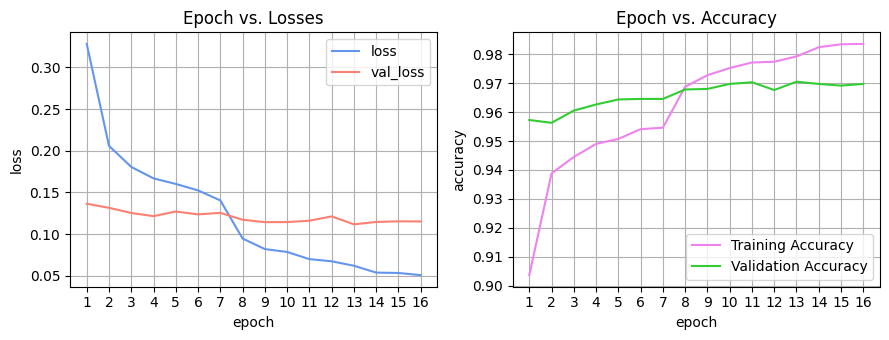

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))
xx = np.arange(1, len(H.history['loss'])+1)
ax = axes[0]
ax.grid()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title("Epoch vs. Losses")
ax.set_xticks(xx)
ax.plot(xx, H.history['loss'], label = 'loss', color='cornflowerblue')
ax.plot(xx, H.history['val_loss'], label = 'val_loss', color='salmon')
ax.legend()

ax = axes[1]
ax.grid()
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.set_title("Epoch vs. Accuracy")
ax.set_xticks(xx)
ax.plot(xx, H.history['SparseCategoricalAccuracy'], label='Training Accuracy', color='violet')
ax.plot(xx, H.history['val_SparseCategoricalAccuracy'], label='Validation Accuracy', color = 'limegreen')
ax.legend()
plt.tight_layout()

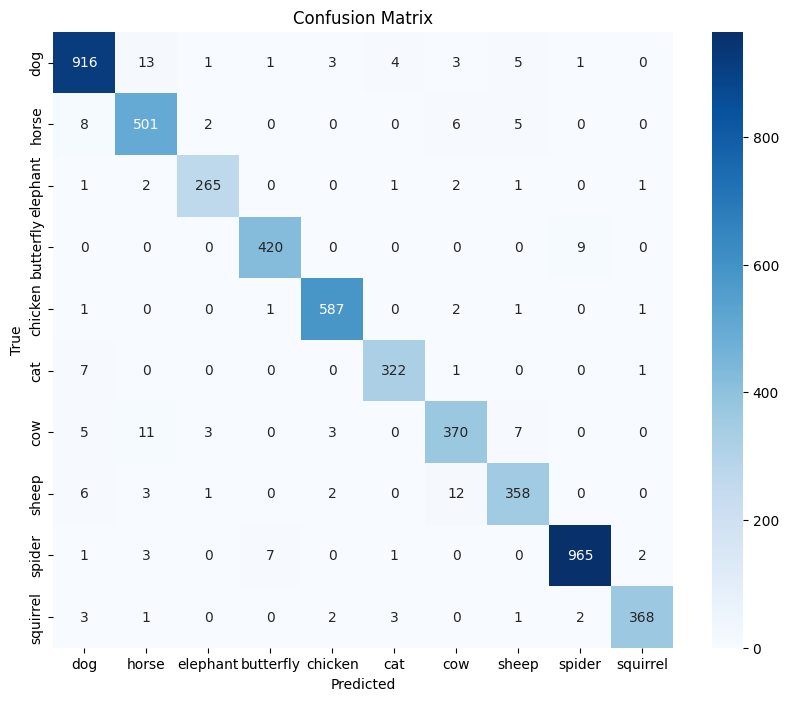

              precision    recall  f1-score   support

         dog       0.97      0.97      0.97       947
       horse       0.94      0.96      0.95       522
    elephant       0.97      0.97      0.97       273
   butterfly       0.98      0.98      0.98       429
     chicken       0.98      0.99      0.99       593
         cat       0.97      0.97      0.97       331
         cow       0.93      0.93      0.93       399
       sheep       0.95      0.94      0.94       382
      spider       0.99      0.99      0.99       979
    squirrel       0.99      0.97      0.98       380

    accuracy                           0.97      5235
   macro avg       0.97      0.97      0.97      5235
weighted avg       0.97      0.97      0.97      5235



In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def get_labels_and_predictions(dataset, model):
    true_labels = []
    predictions = []

    for images, labels in dataset:
        preds = model.predict(images, verbose = 0)
        predicted_classes = np.argmax(preds, axis=1)
        true_labels.extend(labels.numpy())
        predictions.extend(predicted_classes)

    return np.array(true_labels), np.array(predictions)

true_labels, predicted_labels = get_labels_and_predictions(test_dataset, M)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken",
              "gatto": "cat", "mucca": "cow", "pecora": "sheep", "ragno": "spider", "scoiattolo": "squirrel"}
class_names = [translate[i] for i in test_dataset.class_names]

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels = class_names, yticklabels = class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(true_labels, predicted_labels, target_names = class_names))

## **Resumen de Resultados**

- Con el MLP sencillo obtenemos una precisión del 36.6%.
- Usando el Keras Tuner para la arquitectura de red obtenemos una precisión del 37.1%.
- Al realizar el ajuste del Learning rate y BatchSize obtenemos una precisión del 37.19%.
- Al incluir ReduceOnPlateau en los callbacks obtenemos una precisión del 41.47%.
- Con capas convolucionales y de pooling la precisión sube a un 67.47%, sin embargo se presenta mucho overfitting.
- Al hacer regularización se obtiene una precisión del 58.47%, con menos overfitting.
- La EfficientNetB0 obtiene una precisión de 97.61%.
- Empleando la ResNet50 se obtiene una precisión del 96.73%.
- Con Fine-tuning la EfficientNetB0 decrece en un 0.04%, sigue teniendo una buena precisión de 97.57%.
- La Resnet50 mejora en un 0.06% con una precisión de 96.79%. 

El valor del factor de aumento de datos se obtuvo realizando un keras tuner para una red más sencilla con capas convolucionales.

- Al incluir datos aumentados la EfficientNetB0 obtiene una precisión del 96.5%, es lógico que baje levemente su rendimiento dado que se estan incluyendo datos de menor calidad, en general el desempeño sigue siendo bueno y al hacer fine-tuning se esperaría que los resultados mejoren. 
- La ResNet50 al ser una red mucho más robusta se beneficia bastante del aumento de datos y presenta una precisión del 96.89%